# qGANs for Loading Random Distributions

Given $k$-dimensional data samples, we employ a quantum Generative Adversarial Network (qGAN) to learn the data's underlying random distribution and to load it directly into a quantum state:

$$ \big| g_{\theta}\rangle = \sum_{j=0}^{2^n-1} \sqrt{p_{\theta}^{j}}\big| j \rangle $$

where $p_{\theta}^{j}$ describe the occurrence probabilities of the basis states $\big| j\rangle$. 

The aim of the qGAN training is to generate a state $\big| g_{\theta}\rangle$ where $p_{\theta}^{j}$, for $j\in \left\{0, \ldots, {2^n-1} \right\}$, describe a probability distribution that is close to the distribution underlying the training data $X=\left\{x^0, \ldots, x^{k-1} \right\}$.

For further details please refer to [Quantum Generative Adversarial Networks for Learning and Loading Random Distributions](https://arxiv.org/abs/1904.00043) _Zoufal, Lucchi, Woerner_ \[2019\].

For an example of how to use a trained qGAN in an application, the pricing of financial derivatives, please see the
[Option Pricing with qGANs](https://github.com/Qiskit/qiskit-finance/tree/main/docs/tutorials/10_qgan_option_pricing.ipynb) tutorial.

In [29]:
import numpy as np

seed = 42
np.random.seed = seed

import matplotlib.pyplot as plt

%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN, PyTorchDiscriminator
from qiskit_machine_learning.datasets.dataset_helper import discretize_and_truncate

algorithm_globals.random_seed = seed

## Load the Training Data

First, we need to load the $k$-dimensional training data samples (here k=1).

Next, the data resolution is set, i.e. the min/max data values and the number of qubits used to represent each data dimension.

In [30]:
data_dim = [3, 3]

training_data = np.random.default_rng().multivariate_normal(mean=[0., 0.], cov=[[1, 0], [0, 1]], size=1000, check_valid='warn',
                                                        tol=1e-8, method='svd')
# Define minimal and maximal values for the training data
bounds_min = np.percentile(training_data, 5, axis=0)
bounds_max = np.percentile(training_data, 95, axis=0)
bounds = []
for i, _ in enumerate(bounds_min):
    bounds.append([bounds_min[i], bounds_max[i]])

# Pre-processing, i.e., gridding
(training_data,
data_grid,
grid_elements,
prob_data ) = discretize_and_truncate(
training_data,
np.array(bounds),
data_dim,
return_data_grid_elements=True,
return_prob=True,
prob_non_zero=True,
)

# Define the training batch size
batch_size = 100

k = len(data_dim)

## Initialize the qGAN

The qGAN consists of a quantum generator $G_{\theta}$, i.e., an ansatz, and a classical discriminator $D_{\phi}$, a neural network.

To implement the quantum generator, we choose a depth-$1$ ansatz that implements $R_Y$ rotations and $CZ$ gates which takes a uniform distribution as an input state. Notably, for $k>1$ the generator's parameters must be chosen carefully. For example, the circuit depth should be $>1$ because higher circuit depths enable the representation of more complex structures.

The classical discriminator used here is based on a neural network implementation using NumPy. There is also a discriminator based on PyTorch which is not installed by default when installing Qiskit - see [Optional Install](https://github.com/Qiskit/qiskit-machine-learning#optional-installs) for more information.

Here, both networks are updated with the ADAM optimization algorithm (ADAM is qGAN optimizer default).

In [31]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 3
# Batch size
batch_size = 100

# Initialize qGAN
qgan = QGAN(training_data, bounds, data_dim, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = seed
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(
    backend=BasicAer.get_backend("qasm_simulator"), seed_transpiler=seed, seed_simulator=seed
)

g_circuit = QuantumCircuit(sum(data_dim))
g_circuit.h(g_circuit.qubits)
ansatz = TwoLocal(sum(data_dim), "ry", "cx", reps=2, entanglement="circular")
g_circuit.compose(ansatz, inplace=True)

# Set generator's initial parameters - in order to reduce the training time and hence the
# total running time for this notebook
init_params = [-0.62459695, -0.89691746,  0.18693757,  0.39363968,  0.87679446 , 0.3195883,
  0.07501841, -0.56848824 , 0.7865068,   0.30438578, -0.02588749, -0.04123104,
  0.8022851,   0.33377373, -0.67609954, -0.55970764,  0.96877897, -0.65705943]

# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(data_dim))
qgan.set_discriminator(discriminator)

## Run the qGAN Training

During the training the discriminator's and the generator's parameters are updated alternately w.r.t the following loss functions:
$$ L_G\left(\phi, \theta\right) = -\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log\left(D_{\phi}\left(g^{l}\right)\right)\right] $$
and
$$  L_D\left(\phi, \theta\right) =
	\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log D_{\phi}\left(x^{l}\right) + \log\left(1-D_{\phi}\left(g^{l}\right)\right)\right], $$
with $m$ denoting the batch size and $g^l$ describing the data samples generated by the quantum generator.

Please note that the training, for the purpose of this notebook, has been kept briefer by the selection of a known initial point (`init_params`). Without such prior knowledge be aware training may take some while.

In [32]:
# Run qGAN
result = qgan.run(quantum_instance)

d loss  0.6675532502588266
g loss  [0.92171993]
d loss  0.6867219241446415
g loss  [0.91509236]
d loss  0.6585213834942294
g loss  [0.92114731]
d loss  0.6696451519063191
g loss  [0.92413942]
d loss  0.6597783565475077
g loss  [0.92984465]
d loss  0.6696542889049812
g loss  [0.93180095]
d loss  0.669165322584985
g loss  [0.93340544]
d loss  0.6617839805804855
g loss  [0.93715401]
d loss  0.6751735623079433
g loss  [0.93431398]
d loss  0.6576026806394908
g loss  [0.93938713]
d loss  0.6624975987484835
g loss  [0.93880255]
d loss  0.6677129184885416
g loss  [0.93654759]
d loss  0.6466044738940355
g loss  [0.94255441]
d loss  0.6517753257894245
g loss  [0.94502742]
d loss  0.6344745869673136
g loss  [0.95135536]
d loss  0.672152824234224
g loss  [0.94406692]
d loss  0.657119691303445
g loss  [0.94096812]
d loss  0.6564849666655497
g loss  [0.93369454]
d loss  0.6506002433017584
g loss  [0.93651515]
d loss  0.6521881459948271
g loss  [0.94240221]
d loss  0.6347297618899181
g loss  [0.94795

In [33]:
print("Training results:")
for key, value in result.items():
    print(f"  {key} : {value}")

Training results:
  params_d : [ 0.40606666 -0.0869201   0.49768867 ...  0.13959341 -0.07020546
  0.17416054]
  params_g : [-0.62459696 -0.89691746  0.1869376   0.39363968  0.87679445  0.3195883
  0.07501844 -0.56848824  0.78650679  0.30438578 -0.02588746 -0.04123104
  0.80228509  0.33377373 -0.67609951 -0.55970764  0.96877896 -0.65705943]
  loss_d : 0.644
  loss_g : [0.9532]
  rel_entr : 0.787


## Training Progress & Outcome

Now, we plot the evolution of the generator's and the discriminator's loss functions during the training, as well as the progress in the relative entropy between the trained and the target distribution.

Finally, we also compare the cumulative distribution function (CDF) of the trained distribution to the CDF of the target distribution.

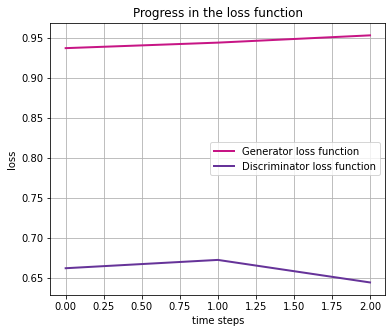

In [34]:
# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6, 5))
plt.title("Progress in the loss function")
plt.plot(
    t_steps, qgan.g_loss, label="Generator loss function", color="mediumvioletred", linewidth=2
)
plt.plot(
    t_steps, qgan.d_loss, label="Discriminator loss function", color="rebeccapurple", linewidth=2
)
plt.grid()
plt.legend(loc="best")
plt.xlabel("time steps")
plt.ylabel("loss")
plt.show()

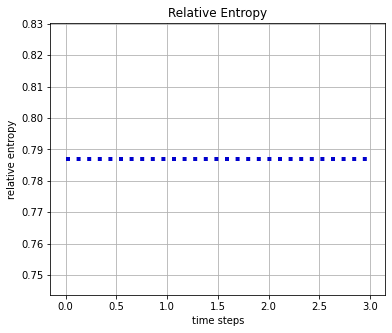

In [35]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6, 5))
plt.title("Relative Entropy")
plt.plot(
    np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color="mediumblue", lw=4, ls=":"
)
plt.grid()
plt.xlabel("time steps")
plt.ylabel("relative entropy")
plt.show()

In [36]:
# Plot the CDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(log_normal == i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6, 5))
plt.title("CDF (Cumulative Distribution Function)")
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g, np.cumsum(prob_g), color="royalblue", width=0.8, label="simulation")
plt.plot(
    np.cumsum(log_normal), "-o", label="log-normal", color="deepskyblue", linewidth=4, markersize=12
)
plt.xticks(np.arange(min(samples_g), max(samples_g) + 1, 1.0))
plt.grid()
plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend(loc="best")
plt.show()

ValueError: operands could not be broadcast together with shapes (100000,) (2,) 

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright